In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from Dataloader import prepare_data_loader
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class Encoder(nn.Module):
    def __init__(self, hidden_size):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3)
        # self.bn1 = nn.BatchNorm2d(4)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3)
        # self.bn2 = nn.BatchNorm2d(8)
        self.conv3 = nn.Conv2d(8, 16, kernel_size=4)
        # self.bn3 = nn.BatchNorm2d(16)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        return x


class Decoder(nn.Module):
    def __init__(self, hidden_size):
        super(Decoder, self).__init__()        
        self.conv1 = nn.ConvTranspose2d(16, 8, kernel_size=4)
        self.conv2 = nn.ConvTranspose2d(8, 4, kernel_size=3)
        self.conv3 = nn.ConvTranspose2d(4, 1, kernel_size=3)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.sigmoid(self.conv3(x))
        return x


class ConvAutoencoder(nn.Module):
    def __init__(self, hidden_size):
        super(ConvAutoencoder, self).__init__()
        self.encoder = Encoder(hidden_size)
        self.decoder = Decoder(hidden_size)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def save_encoder(self, path):
        torch.save(self.encoder.state_dict(), path)

In [4]:
training_data_dir = './data/lunar/training/data/S12_GradeA/'
training_labels_file = './data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv'

train_loader = prepare_data_loader(overlap=0.25,
                                  window_length=1,
                                  decimation_factor=3,
                                  spect_nfft=128,
                                  spect_nperseg=128,
                                  batch_size=128,
                                  data_dir=training_data_dir,
                                  labels_file_path=training_labels_file)

Starting number of files:76
Number of uniques files:71
(6633, 65, 70)
(6633,)
Number of windows with seismic event 299
Noise sample weight: 0.04507764209256747
Event sample weight: 0.9549223579074325


In [54]:
height, width = train_loader.dataset.tensors[0].shape[1:]
height, width, height * width

(65, 70, 4550)

In [59]:
class Autoencoder(nn.Module):
    def __init__(self, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(height * width, hidden_size),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, height * width),
            nn.Unflatten(1, (height, width)),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [60]:
tensors = list(train_loader.dataset.tensors)
tensors[0] = tensors[0] / tensors[0].max()
train_loader.dataset.tensors = tuple(tensors)

In [61]:
# autoencoder = ConvAutoencoder(hidden_size=200).to(device)
autoencoder = Autoencoder(hidden_size=4550).to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-5)
criterion = nn.MSELoss()

epoch [1/50], loss: 0.004055745899677277
epoch [2/50], loss: 0.0015566842630505562
epoch [3/50], loss: 0.0008661102037876844
epoch [4/50], loss: 0.0005435952334664762
epoch [5/50], loss: 0.00041283227619715035
epoch [6/50], loss: 0.0003825094609055668
epoch [7/50], loss: 0.0002457573136780411
epoch [8/50], loss: 0.00014632410602644086
epoch [9/50], loss: 0.00016325869364663959
epoch [10/50], loss: 0.00018153748533222824
epoch [11/50], loss: 8.315661398228258e-05
epoch [12/50], loss: 0.00012810657790396363
epoch [13/50], loss: 0.00017917799414135516
epoch [14/50], loss: 7.168371666921303e-05
epoch [15/50], loss: 5.1045288273599e-05
epoch [16/50], loss: 5.765600872109644e-05
epoch [17/50], loss: 5.791503281216137e-05
epoch [18/50], loss: 3.710193050210364e-05
epoch [19/50], loss: 0.00010554226173553616
epoch [20/50], loss: 3.548951281118207e-05
epoch [21/50], loss: 4.277086918591522e-05
epoch [22/50], loss: 4.201432238915004e-05
epoch [23/50], loss: 6.192122236825526e-05
epoch [24/50], l

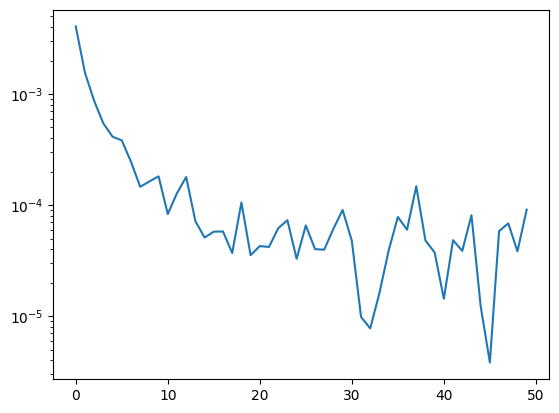

In [63]:
num_epochs = 50
all_losses = []
autoencoder.train()
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        output = autoencoder(img)
        loss = criterion(output, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'epoch [{epoch + 1}/{num_epochs}], loss: {loss.item()}')
    all_losses.append(loss.item())

# autoencoder.save_encoder('./models/encoder.pth')
plt.plot(all_losses)
plt.yscale('log')
plt.show()

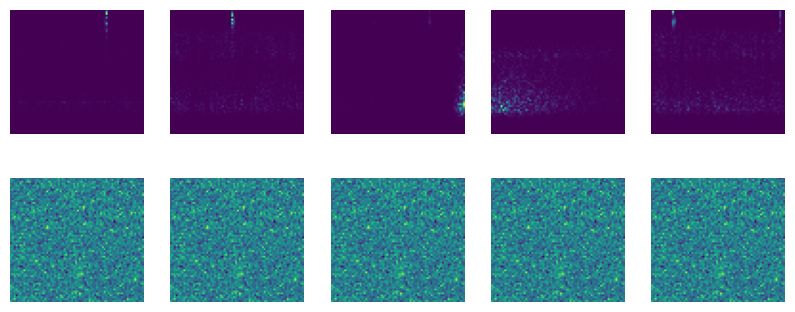

In [64]:
plt.figure(figsize=(10, 4))
autoencoder.eval()
with torch.no_grad():
    img, _ = next(iter(train_loader))
    img = img.reshape(-1, 1, height, width).to(device)
    output = autoencoder(img)
    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.imshow(img[i].cpu().numpy().squeeze())
        plt.axis('off')
        plt.subplot(2, 5, i + 6)
        plt.imshow(output[i].cpu().numpy().squeeze())
        plt.axis('off')

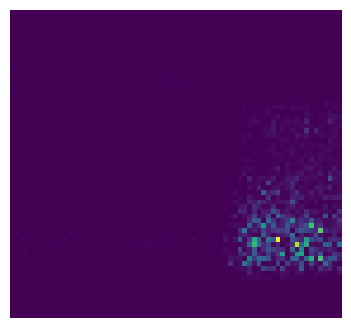

In [48]:
plt.figure(figsize=(10, 4))
autoencoder.eval()
with torch.no_grad():
    img, _ = next(iter(train_loader))
    img = img.reshape(-1, 1, height, width).to(device)
    plt.imshow(img[0].cpu().numpy().squeeze())
    plt.axis('off')

In [49]:
max(img[0].reshape(-1))

tensor(0.0017, device='cuda:0')

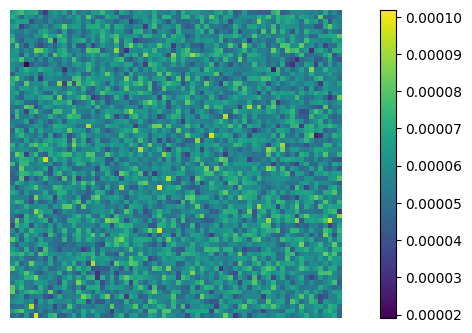

In [50]:
plt.figure(figsize=(10, 4))
autoencoder.eval()
with torch.no_grad():
    img, _ = next(iter(train_loader))
    img = img.reshape(-1, 1, height, width).to(device)
    output = autoencoder(img)
    plt.imshow(output[0].cpu().numpy().squeeze())
    plt.colorbar()
    plt.axis('off')

In [51]:
min(output[0].reshape(-1)), max(output[0].reshape(-1))

(tensor(1.9162e-05, device='cuda:0'), tensor(0.0001, device='cuda:0'))

In [52]:
output[0] = torch.where(output[0] > max(img[0].reshape(-1)), max(img[0].reshape(-1)), output[0])
min(output[0].reshape(-1)), max(output[0].reshape(-1))

(tensor(1.9162e-05, device='cuda:0'), tensor(0.0001, device='cuda:0'))

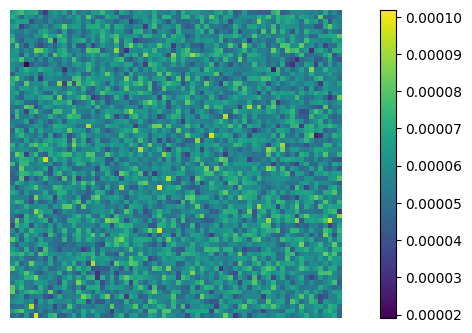

In [53]:
plt.figure(figsize=(10, 4))
autoencoder.eval()
with torch.no_grad():
    plt.imshow(output[0].cpu().numpy().squeeze())
    plt.colorbar()
    plt.axis('off')